# Baseline analysis of wikipedia discussions in spanish

In this analysis, we are going to automatically identify the kind of opinion of authors in the discussions on talk pages of spanish wikipedia.

In [70]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('seaborn-paper')

Load our labelled dataset, containing the opinions in the talk pages of wikipedia segmented by sentences assuming normal punctuation. This dataset includes the initial 1000 edits of talk pages of political leaders in America.

In [71]:
ds = pd.read_csv('data/wdds_v01.csv')
ds['creation_dt'] = pd.to_datetime(ds['timestamp'], unit='s')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 12 columns):
row_id         1203 non-null int64
page_id        1203 non-null int64
page_title     1203 non-null object
contributor    1203 non-null object
timestamp      1203 non-null int64
topic          1122 non-null object
opinion        1203 non-null object
type           1203 non-null int64
subtype        1203 non-null int64
stance         1203 non-null int64
sentiment      1203 non-null int64
creation_dt    1203 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 112.9+ KB


In [72]:
ds.head()

,row_id,page_id,page_title,contributor,timestamp,topic,opinion,type,subtype,stance,sentiment,creation_dt
0,0,581601,Discusión:Rafael Correa,194.98.136.11,1216717599,NaN,http://www.hoy.com.ec/temas/temas2008/correa/c...,2,6,0,-1,2008-07-22 09:06:39
1,1,581601,Discusión:Rafael Correa,194.98.136.11,1216717599,NaN,los cuadros aparecen en:,1,4,-1,1,2008-07-22 09:06:39
2,2,581601,Discusión:Rafael Correa,194.98.136.11,1216717599,NaN,http://www.hoy.com.ec/temas/temas2008/correa/c...,2,4,-1,1,2008-07-22 09:06:39
3,3,581601,Discusión:Rafael Correa,Nihilo,1172447487,democrático y cristiano,"decir que es próximo a la ""democracia cristian...",2,3,0,0,2007-02-25 23:51:27
4,4,581601,Discusión:Rafael Correa,Nihilo,1172447487,democrático y cristiano,también es una pedrada decir que se encuentra ...,0,5,1,-1,2007-02-25 23:51:27


remove unnecesary label 'discusión' in title

In [73]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

# exploratory analysis
Lets look the distribution of discussions per talk page

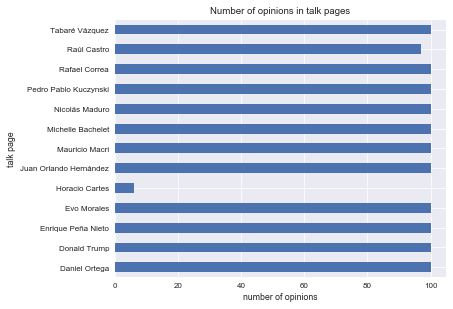

In [79]:
discussion_perpage= ds.groupby('page_title').size()
discussion_perpage.plot.barh()
plt.xlabel('number of opinions')
plt.ylabel('talk page')
plt.title('Number of opinions in talk pages')
plt.tight_layout()
plt.savefig('opiniontalkpagesdist.eps', format='eps')

almost all talk pages have same sample size, except one.  Now, lets look at the number of opinions by editor.

In [59]:
print(f'unique authors: {ds.contributor.nunique()}')

unique authors: 177


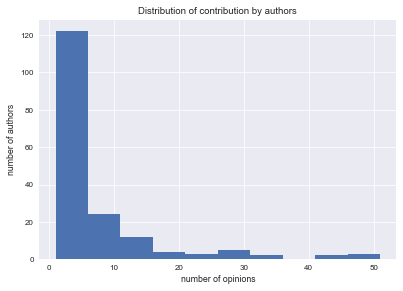

In [80]:
discussion_pereditor= ds.groupby('contributor').size()
discussion_pereditor= discussion_pereditor.sort_values(ascending=False)
discussion_pereditor.hist()
plt.xlabel('number of opinions')
plt.ylabel('number of authors')
plt.title('Distribution of contribution by authors')
plt.savefig('authorcontribdist.eps', format='eps')

Most authors have 10 or less opinions.  It could be useful to know if there are authors with opinions in multiple talk pages

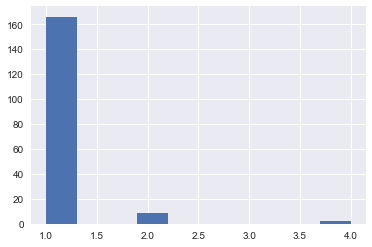

In [47]:
discussion_pereditor=ds.groupby(['contributor', 'page_title']).size().reset_index()
discussion_pereditor=discussion_pereditor['contributor'].value_counts()
discussion_pereditor.hist()

Most authors only contribute to one discussions, with few authors contributing to two or more discussions.  Another aspect, it is the temporal distribution, lets look at it:

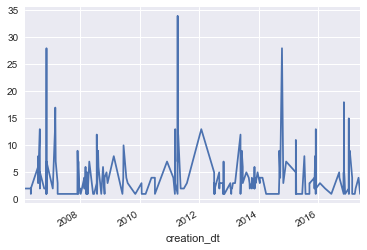

In [12]:
ts = ds.groupby(['creation_dt']).size()
ts.plot()

it seems there's some spikes at certain dates, probably related to real world events.  Now, let make the text analysis of the opinions.

# text analysis

First, lets look characterize the opinions. First, let's analyze the length of the opinions and number of words

In [84]:
ds['oplen'] = ds.opinion.str.len()

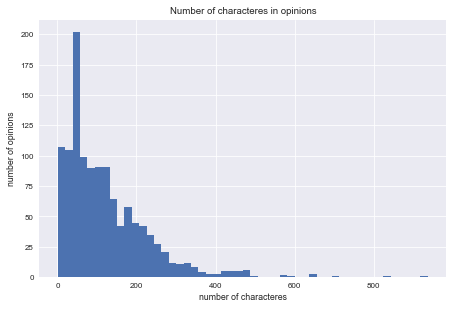

In [89]:
ds.oplen.hist(bins=50)
plt.xlabel('number of characteres')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('numcharsopdist.eps', format='eps')

as in most human activities, the length of opinions follow an power law distribution.  Now, let's look at the number of words:

In [91]:
from nltk.tokenize import word_tokenize

In [113]:
ds['opnumwords'] = ds.opinion.apply(lambda s: len(word_tokenize(s, 'spanish')))

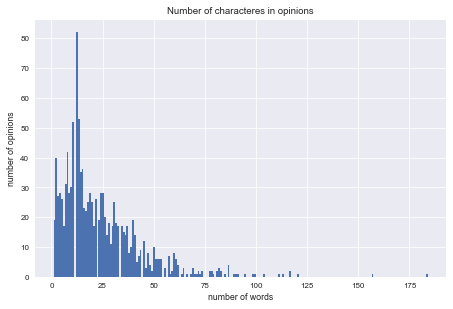

In [114]:
ds.opnumwords.hist(bins=200)
plt.xlabel('number of words')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('numwordsopdist.eps', format='eps')

as expected the distribution of length of words is very similar to characters in opinions. Although there are opinions with only one word, it may be useful to know what kind of opinions are those:

In [115]:
ds[ds.opnumwords<2].opinion.value_counts()

0               4
etc..           2
|-              1
2               1
saludos         1
1               1
______          1
paz             1
messhermit      1
3               1
...             1
criminalidad    1
!               1
4               1
gracias         1
Name: opinion, dtype: int64

some of them are meaningless others make sense such as: saludos, paz, gracias.  One of the challeges in the classification task will be to filter out meaningless words but filtering out useful words, specially when both have the similar frequencies.  Let's look at most used words with a word cloud.

# classification task